In [1]:
import imaging_behavior_functions
import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json
from scipy.integrate import quad

In [2]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/hDeltaB_imaging/qualified_sessions/odor_trials/to_check/"
example_path_data = base_path+"20230612-5_EPGhDeltaB_syntGCAMP7f_odor_apple/data/"
example_path_results = base_path+"20230612-5_EPGhDeltaB_syntGCAMP7f_odor_apple/results/"
trial_num = 4
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

### EPG processing 

In [3]:
epg_df = neural_df.filter(like='EPG')
epg_df

,EPG_0,EPG_1,EPG_2,EPG_3,EPG_4,EPG_5,EPG_6,EPG_7,EPG_8,EPG_9,EPG_10,EPG_11,EPG_12,EPG_13,EPG_14,EPG_15,EPG_16,EPG_17,EPG_18,EPG_19
0,2.123552,0.218738,-0.148508,-0.186903,-0.129852,0.529102,1.664679,2.766589,1.282635,1.590100,0.648141,0.145633,-0.079476,0.533349,0.946825,2.881148,2.042330,2.840998,1.753959,4.122192
1,2.339182,0.265705,-0.081114,-0.167761,-0.104972,0.523565,1.652945,2.717179,1.479184,1.524765,0.671007,0.160839,-0.154789,0.477413,1.135738,3.108676,2.177593,2.726797,1.807253,4.162457
2,2.414749,0.362543,-0.017293,-0.152619,-0.089217,0.436905,1.671404,2.603844,1.587493,1.624771,0.729332,0.189056,-0.190705,0.489330,1.227410,3.254852,2.172185,2.515282,1.760716,4.116477
3,2.516689,0.459885,0.021140,-0.109332,-0.083065,0.453170,1.801625,2.663141,1.595478,1.571430,0.743979,0.256927,-0.158885,0.559662,1.083862,3.199929,2.073374,2.476122,1.709429,4.202104
4,2.325236,0.581514,0.078583,-0.075377,-0.078431,0.459752,1.759934,2.672171,1.558765,1.560130,0.878975,0.407642,-0.138938,0.522292,0.877165,2.946658,2.062473,2.463444,1.849155,4.220924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2.508355,1.557092,1.016293,0.769859,0.451895,0.397756,0.778293,1.562007,1.974795,2.475644,1.447533,0.967584,0.560099,0.351296,0.871621,1.811532,1.960243,2.002627,2.209986,2.889559
1436,3.240599,1.596387,1.033308,0.729165,0.336321,0.342714,0.712024,1.530619,2.047822,2.440815,1.221365,0.923117,0.521009,0.360726,0.760885,1.786373,1.852697,1.998329,2.273403,3.325033
1437,3.562220,1.481090,0.938564,0.672315,0.238538,0.291199,0.690883,1.417381,1.930989,2.445978,1.233075,0.873929,0.441552,0.313149,0.629185,1.719398,1.908567,2.130847,2.339158,3.655367
1438,3.253513,1.338461,0.795265,0.605324,0.169635,0.339534,0.728594,1.341219,1.931558,2.492775,1.212957,0.795217,0.407603,0.364316,0.599839,1.552956,1.942750,2.171428,2.336427,3.696334


<Axes: >

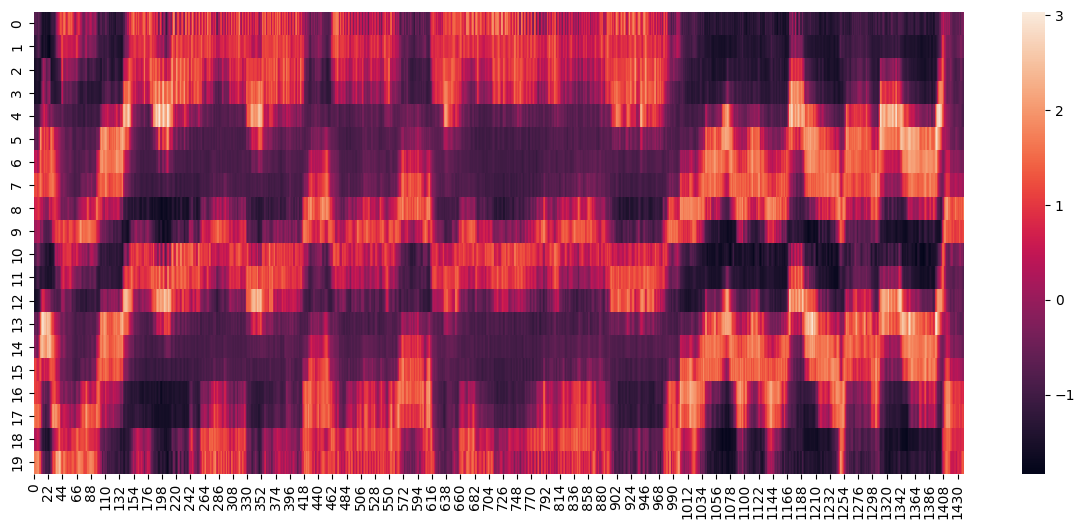

In [4]:
scaler = StandardScaler()
roi_mtx_ori =  epg_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

In [5]:
pva_phase, pva_amplitude = imaging_behavior_functions.calculate_pva(np.transpose(roi_mtx))

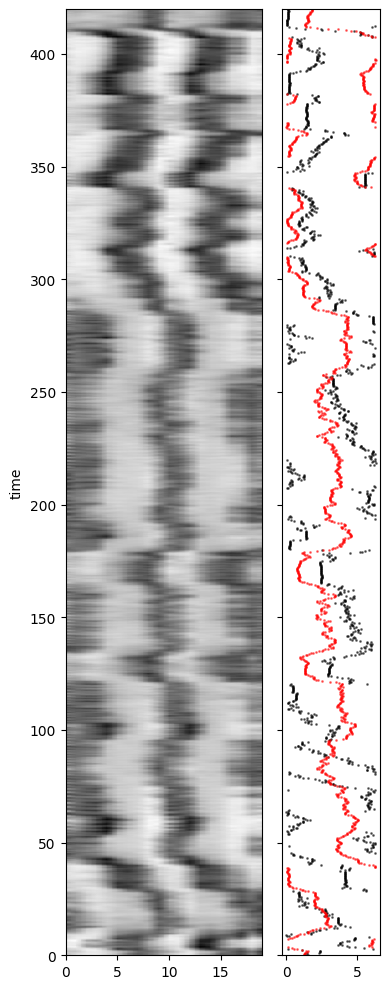

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [2, 1]})
ind1 = 0
ind2 = len(epg_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.scatter(2*np.pi-behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()



Text(0, 0.5, 'heading')

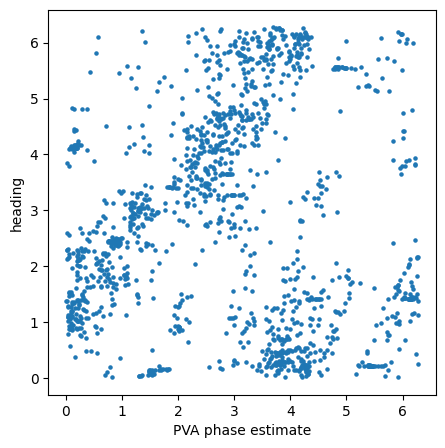

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pva_phase+np.pi, 2*np.pi-behav_df.heading, marker = 'o',s=5)
ax.set_xlabel('PVA phase estimate')
ax.set_ylabel('heading')

In [38]:
def calculate_translational_velocity_df(df):
    """
    Calculate translational velocities and directions for multiple time points provided in a DataFrame.

    Parameters:
        df (pandas.DataFrame): DataFrame containing columns 'fwV' for forward velocity (mm/s) 
                               and 'sideV' for side velocity (rad/s).
        radius (float): Radius of the ball in mm.
        heading_direction_rad (float): Instantaneous heading direction of the animal in radians (assumed constant for simplicity).

    Returns:
        pandas.DataFrame: DataFrame with additional columns 'translational_velocity_mm_s' and 'translational_direction_rad'.
    """
    # Convert side velocity from rad/s to mm/s
    #df['side_velocity_mm'] = df['sideV'] * radius

    # Calculate the magnitude of the translational velocity
    df['translational_velocity_mm_s'] = np.sqrt(df['sideV']**2 + df['fwV']**2)

    # Calculate the direction of the translational velocity
    df['translational_direction_rad'] = (df['heading'] + np.arctan2(df['sideV'], df['fwV'])) % (2*np.pi)


    return df

radius = 4.5 
result_df = calculate_translational_velocity_df(behav_df)
result_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos,translational_velocity_mm_s,translational_direction_rad
0,0.000000,0.000000,0.000000,0.000000,4.785103,0.000000,0.000000,0.000000,0,4.785103,-0.000000,0.000000,0.000000,0.000000,4.785103
1,0.291809,2.076647,-0.166323,3.163322,4.800690,0.166323,3.163322,5.406293,1,4.800690,-0.007597,0.006708,0.603258,2.083297,4.720769
2,0.583618,-0.179120,-2.502673,0.057857,4.938685,2.502673,0.057857,2.739650,1,4.938685,-0.007214,-0.047573,0.517728,2.509075,3.296439
3,0.875427,-1.706512,-4.777215,-1.683990,4.831111,4.777215,1.683990,8.167716,1,4.831111,-0.007136,-0.151374,-0.053497,5.072865,2.917223
4,1.167236,-4.137329,-2.517293,-7.869919,3.994879,2.517293,7.869919,14.524541,1,3.994879,-0.007818,0.706712,-0.960756,4.842960,1.399884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,418.745805,-0.224995,-0.620285,0.159821,6.128134,0.620285,0.159821,1.005102,1,37.544060,-0.210895,183.598026,212.000603,0.659831,4.209368
1436,419.037614,0.149272,11.477321,-0.033477,6.123084,11.477321,0.033477,11.660070,1,37.539011,-0.211660,183.864306,211.872584,11.478291,1.397690
1437,419.329423,0.178869,2.435003,-0.094570,6.131838,2.435003,0.094570,2.708443,1,37.547765,-0.209642,183.962440,211.854474,2.441564,1.346123
1438,419.621232,0.092287,0.738063,0.357817,6.134061,0.738063,0.357817,1.188168,1,37.549987,-0.215046,184.003010,211.851363,0.743810,1.297277


In [40]:
min(result_df.translational_direction_rad)

0.017181075772198018

In [41]:
neural_df

,time,EPG_0,EPG_1,EPG_2,EPG_3,EPG_4,EPG_5,EPG_6,EPG_7,EPG_8,...,HdELTAb_13,HdELTAb_14,HdELTAb_15,HdELTAb_16,HdELTAb_17,HdELTAb_18,HdELTAb_19,HdELTAb_20,HdELTAb_21,HdELTAb_22
0,0.000000,2.123552,0.218738,-0.148508,-0.186903,-0.129852,0.529102,1.664679,2.766589,1.282635,...,0.962736,1.628945,1.969000,1.289596,0.929122,0.620850,0.758899,0.833563,0.845813,0.600527
1,0.291809,2.339182,0.265705,-0.081114,-0.167761,-0.104972,0.523565,1.652945,2.717179,1.479184,...,0.890183,1.525963,1.828362,1.309875,0.917039,0.679198,0.796773,0.860605,0.952088,0.580174
2,0.583618,2.414749,0.362543,-0.017293,-0.152619,-0.089217,0.436905,1.671404,2.603844,1.587493,...,0.859710,1.375951,1.620608,1.314496,0.978418,0.744582,0.850893,0.881250,1.007082,0.586355
3,0.875427,2.516689,0.459885,0.021140,-0.109332,-0.083065,0.453170,1.801625,2.663141,1.595478,...,0.891497,1.230353,1.436646,1.255457,1.027963,0.822366,0.900984,0.914751,0.956959,0.575706
4,1.167236,2.325236,0.581514,0.078583,-0.075377,-0.078431,0.459752,1.759934,2.672171,1.558765,...,0.922395,1.111986,1.345961,1.187644,0.993008,0.853779,0.938907,0.989143,0.871403,0.611173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,418.745805,2.508355,1.557092,1.016293,0.769859,0.451895,0.397756,0.778293,1.562007,1.974795,...,0.459658,0.620118,0.474825,0.582993,0.408639,0.380190,0.194178,0.198383,0.194573,0.184219
1436,419.037614,3.240599,1.596387,1.033308,0.729165,0.336321,0.342714,0.712024,1.530619,2.047822,...,0.454522,0.555758,0.459578,0.414410,0.331994,0.295390,0.136045,0.094749,0.178659,0.157617
1437,419.329423,3.562220,1.481090,0.938564,0.672315,0.238538,0.291199,0.690883,1.417381,1.930989,...,0.383800,0.457537,0.387147,0.260383,0.296694,0.226079,0.130681,0.066187,0.219055,0.153683
1438,419.621232,3.253513,1.338461,0.795265,0.605324,0.169635,0.339534,0.728594,1.341219,1.931558,...,0.267195,0.378482,0.281510,0.153172,0.187258,0.087509,0.073300,0.047794,0.164404,0.107742


In [42]:
hdeltab_df = neural_df.filter(like='HdELTAb')
hdeltab_df

,HdELTAb_0,HdELTAb_1,HdELTAb_2,HdELTAb_3,HdELTAb_4,HdELTAb_5,HdELTAb_6,HdELTAb_7,HdELTAb_8,HdELTAb_9,...,HdELTAb_13,HdELTAb_14,HdELTAb_15,HdELTAb_16,HdELTAb_17,HdELTAb_18,HdELTAb_19,HdELTAb_20,HdELTAb_21,HdELTAb_22
0,0.253096,0.326449,0.144966,0.190042,0.115032,-0.097400,0.050757,0.078384,-0.034762,0.228514,...,0.962736,1.628945,1.969000,1.289596,0.929122,0.620850,0.758899,0.833563,0.845813,0.600527
1,0.284769,0.377355,0.185251,0.138288,0.065373,-0.107807,0.048618,-0.004318,-0.075221,0.090252,...,0.890183,1.525963,1.828362,1.309875,0.917039,0.679198,0.796773,0.860605,0.952088,0.580174
2,0.302813,0.449339,0.269488,0.127788,0.060606,-0.083922,0.066111,-0.006279,-0.111824,-0.023955,...,0.859710,1.375951,1.620608,1.314496,0.978418,0.744582,0.850893,0.881250,1.007082,0.586355
3,0.330553,0.462587,0.344048,0.212875,0.108900,-0.077035,0.106033,0.042316,-0.119433,-0.056721,...,0.891497,1.230353,1.436646,1.255457,1.027963,0.822366,0.900984,0.914751,0.956959,0.575706
4,0.439023,0.479460,0.429715,0.355802,0.182010,-0.040395,0.137927,0.050017,-0.086290,-0.022112,...,0.922395,1.111986,1.345961,1.187644,0.993008,0.853779,0.938907,0.989143,0.871403,0.611173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.387016,0.392445,0.427822,0.496420,0.447395,0.557567,0.513669,0.616127,0.599597,0.667702,...,0.459658,0.620118,0.474825,0.582993,0.408639,0.380190,0.194178,0.198383,0.194573,0.184219
1436,0.556518,0.553570,0.644257,0.726621,0.629773,0.716976,0.611361,0.736948,0.717042,0.685626,...,0.454522,0.555758,0.459578,0.414410,0.331994,0.295390,0.136045,0.094749,0.178659,0.157617
1437,0.840599,0.878383,0.993383,1.011933,0.826444,0.976888,0.699072,0.852237,0.740904,0.552174,...,0.383800,0.457537,0.387147,0.260383,0.296694,0.226079,0.130681,0.066187,0.219055,0.153683
1438,1.111671,1.106867,1.195519,1.188124,0.954090,1.187953,0.726828,0.866805,0.714361,0.455058,...,0.267195,0.378482,0.281510,0.153172,0.187258,0.087509,0.073300,0.047794,0.164404,0.107742


<Axes: >

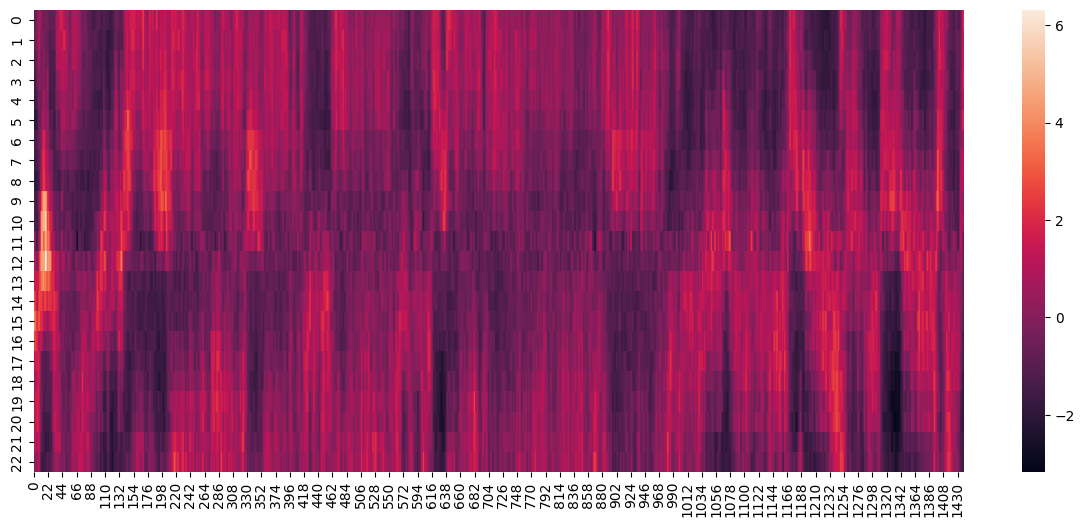

In [43]:
scaler = StandardScaler()
roi_mtx_ori =  hdeltab_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

In [44]:
param_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
param_df

,time,phase,baseline,amplitude,phase_error,baseline_error,amplitude_error
0,0.000000,4.569589,0.240915,2.148997,0.102361,0.158514,0.228294
1,0.291809,4.569589,0.150158,2.156499,0.093095,0.144906,0.209012
2,0.583618,4.569589,0.077632,2.108404,0.081191,0.123648,0.178470
3,0.875427,4.855189,0.038193,2.014604,0.077620,0.112914,0.162929
4,1.167236,4.855189,0.052572,1.896715,0.080346,0.109933,0.158485
...,...,...,...,...,...,...,...
1435,418.745805,2.855993,-0.114025,0.892084,0.091581,0.056754,0.078799
1436,419.037614,2.570394,-0.041934,0.981009,0.104579,0.072280,0.101845
1437,419.329423,1.999195,0.037438,1.093372,0.140066,0.110133,0.158317
1438,419.621232,1.713596,-0.007811,1.392976,0.150315,0.151235,0.218279


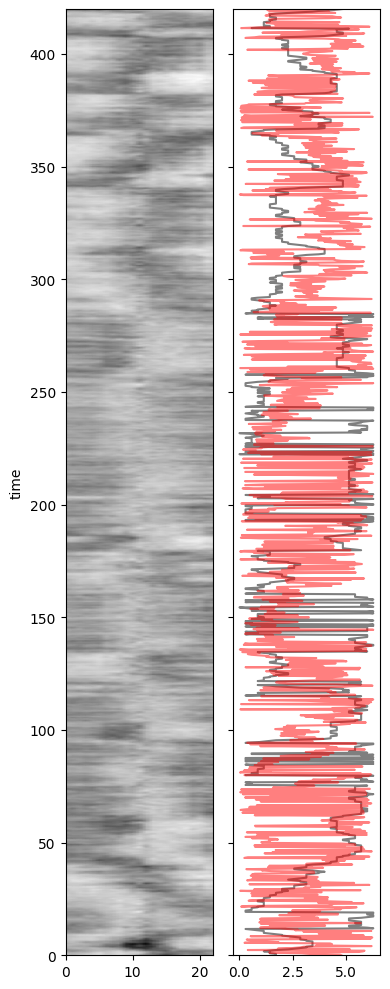

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [1, 1]})
ind1 = 0
ind2 = len(hdeltab_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.plot(2*np.pi-param_df.phase, behav_df.time, color='black',alpha=0.5,label='heading')
ax2.plot(result_df.translational_direction_rad, behav_df.time, color='red',alpha=0.5,label='translational direction')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'heading')

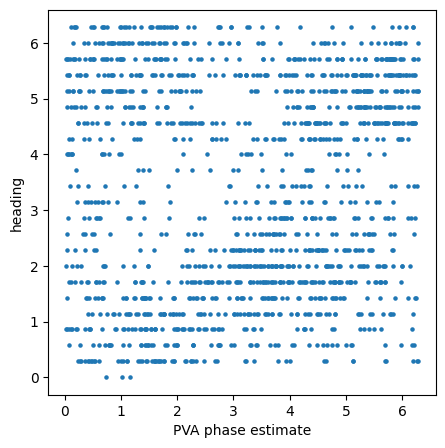

In [46]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(result_df.translational_direction_rad, 2*np.pi-param_df.phase, marker = 'o',s=5)
ax.set_xlabel('PVA phase estimate')
ax.set_ylabel('heading')

Text(0, 0.5, 'bump amplitude')

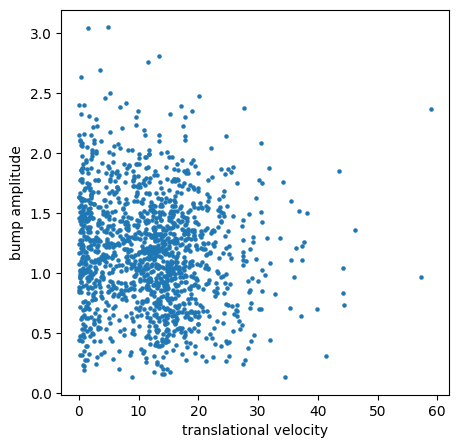

In [47]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(result_df.translational_velocity_mm_s, param_df.amplitude, marker = 'o',s=5)
ax.set_xlabel('translational velocity')
ax.set_ylabel('bump amplitude')